# Imports

In [1]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
import wandb
from pytorch_lightning.loggers import WandbLogger
import torch
import torch.nn as nn
import torch.nn.functional as F 

c:\Users\alexg\anaconda3\lib\site-packages\transformers\utils\generic.py:482: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\alexg\anaconda3\lib\site-packages\transformers\utils\generic.py:339: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\alexg\anaconda3\lib\site-packages\transformers\utils\generic.py:339: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\alexg\anaconda3\lib\site-packages\transformers\utils\generic.py:339: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._regist

# Data Splitting

In [2]:
import os
import random
import shutil
import numpy as np
from PIL import Image

# Paths to the original labeled dataset and output directories for train/validation splits
ORIGINAL_DATASET_DIR = "./Labelled_Images"  # Root folder with class subfolders
TRAIN_DIR = "./train_data/images"
VAL_DIR = "./val_data/images"
TRAIN_MASK_DIR = "./train_data/masks"
VAL_MASK_DIR = "./val_data/masks"

# Create output directories
for dir_path in [TRAIN_DIR, VAL_DIR, TRAIN_MASK_DIR, VAL_MASK_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Define the split ratio
train_ratio = 0.8  # 80% for training, 20% for validation

# Define classes and labels
classes = ["background", "multi", "single-hex", "single-square"]

# Split images and generate masks
for class_idx, cls in enumerate(classes):
    class_dir = os.path.join(ORIGINAL_DATASET_DIR, cls)
    if not os.path.exists(class_dir):
        print(f"Class folder '{cls}' not found in '{ORIGINAL_DATASET_DIR}'. Skipping.")
        continue

    images = os.listdir(class_dir)
    random.shuffle(images)

    # Split images
    split_idx = int(len(images) * train_ratio)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Process training images
    for img in train_images:
        src_path = os.path.join(class_dir, img)
        dest_path = os.path.join(TRAIN_DIR, img)
        shutil.copy(src_path, dest_path)

        # Create and save the corresponding mask
        mask = np.full((128, 128), class_idx, dtype=np.uint8)  # Class label for all pixels
        mask_path = os.path.join(TRAIN_MASK_DIR, os.path.splitext(img)[0] + "_mask.png")
        Image.fromarray(mask).save(mask_path)

    # Process validation images
    for img in val_images:
        src_path = os.path.join(class_dir, img)
        dest_path = os.path.join(VAL_DIR, img)
        shutil.copy(src_path, dest_path)

        # Create and save the corresponding mask
        mask = np.full((128, 128), class_idx, dtype=np.uint8)
        mask_path = os.path.join(VAL_MASK_DIR, os.path.splitext(img)[0] + "_mask.png")
        Image.fromarray(mask).save(mask_path)

print("Data has been split into train and validation sets with masks.")


Data has been split into train and validation sets with masks.


# Model Definition and Training

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms.functional import hflip, rotate, adjust_brightness
from torch.optim.lr_scheduler import CosineAnnealingLR
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, augment=False):
        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = mask.resize((128, 128), resample=Image.NEAREST)  # Resize to match model output

        # Convert mask to numpy array for transformations
        mask = np.array(mask, dtype=np.int64)

        if self.augment:
            # Apply augmentations
            if np.random.rand() > 0.5:
                image = hflip(image)
                mask = np.fliplr(mask)
            if np.random.rand() > 0.5:
                angle = np.random.uniform(-30, 30)
                image = rotate(image, angle)
                mask = np.array(Image.fromarray(mask).rotate(angle, resample=Image.NEAREST))
            if np.random.rand() > 0.5:
                brightness_factor = np.random.uniform(0.7, 1.3)
                image = adjust_brightness(image, brightness_factor)

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

class PixelSegmentationCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(PixelSegmentationCNN, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2)  # Downsample
        
        # Decoder
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)  # Predict per-pixel class scores
        )
        
        # 1x1 Convolutions for Skip Connections
        self.conv1x1_3 = nn.Conv2d(128, 128, kernel_size=1)  # for x2
        self.conv1x1_2 = nn.Conv2d(64, 64, kernel_size=1)    # for x1
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
    
    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)        # Shape: (batch, 64, 128, 128)
        x = self.pool(x1)        # Shape: (batch, 64, 64, 64)
        x2 = self.enc2(x)        # Shape: (batch, 128, 64, 64)
        x = self.pool(x2)        # Shape: (batch, 128, 32, 32)
        x3 = self.enc3(x)        # Shape: (batch, 256, 32, 32)
        
        # Decoder with skip connections
        x = self.upsample(x3)    # Shape: (batch, 256, 64, 64)
        x = self.dec3(x)         # Shape: (batch, 128, 64, 64)
        x = x + self.conv1x1_3(x2)  # Skip connection from x2
        
        x = self.upsample(x)     # Shape: (batch, 128, 128, 128)
        x = self.dec2(x)         # Shape: (batch, 64, 128, 128)
        x = x + self.conv1x1_2(x1)  # Skip connection from x1
        
        x = self.dec1(x)         # Final output: (batch, num_classes, 128, 128)
        return x

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize datasets and data loaders
train_dataset = SegmentationDataset("./train_data/images", "./train_data/masks", transform=transform)
val_dataset = SegmentationDataset("./val_data/images", "./val_data/masks", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Define the segmentation model
class SegmentationModel(pl.LightningModule):
    def __init__(self, num_classes=4):
        super(SegmentationModel, self).__init__()
        self.model = PixelSegmentationCNN(num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()  # Pixel-wise loss

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, masks)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, masks)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# Train the model
wandb_logger = WandbLogger(project="Pixel_Segmentation")

model = SegmentationModel(num_classes=4)

trainer = pl.Trainer(
    max_epochs=100,
    devices=1 if torch.cuda.is_available() else 0,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=wandb_logger
)

trainer.fit(model, train_loader, val_loader)
wandb.finish()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PixelSegmentationCNN | 1.6 M 
1 | criterion | CrossEntropyLoss     | 0     
---------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.298     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▇▃▃▆▄▄▂▁▄
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂
epoch,20
train_loss,0.651
trainer/global_step,545
val_loss,0.7986


# Model Testing

Background: 54.57%
Multi-Layer: 10.13%
Single Hexagonal: 6.00%
Single Square: 29.29%


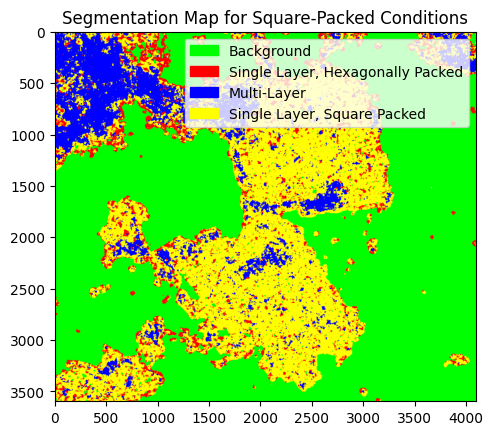

In [24]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as mpatches

# Load the trained segmentation model
# model = SegmentationModel(num_classes=4)  # Ensure num_classes matches your model
# model.load_state_dict(torch.load("path/to/your/trained_model.pth"))  # Update with your model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)
model.eval()

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Path for the TIFF image
image_path = "36kImages/36000 x 1749 Ceta.tif"

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
# Crop the image to remove the bottom 500 pixels
width, height = image.size
image = image.crop((0, 0, width, height - 500))  # (left, upper, right, lower)

# Transform the cropped image into a tensor
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the segmentation map
with torch.no_grad():
    output = model(input_tensor)  # Output shape: [1, num_classes, H, W]
    predicted_classes = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: [H, W]

# Define colormap for visualization
height, width = predicted_classes.shape
colormap = np.zeros((height, width, 3), dtype=np.uint8)

# Set colors for each class
class_colors = {
    0: (0, 255, 0),   # Background (Green)
    1: (0, 0, 255),   # Multi (Blue)
    2: (255, 0, 0),   # Single Hex (Red)
    3: (255, 255, 0), # Single Square (Yellow)
}

# Fill the colormap
for class_label, color in class_colors.items():
    colormap[predicted_classes == class_label] = color

# Calculate percentages
total_pixels = height * width
class_counts = [np.sum(predicted_classes == label) for label in class_colors.keys()]
percentages = [(count / total_pixels) * 100 for count in class_counts]

# Print percentages
print(f"Background: {percentages[0]:.2f}%")
print(f"Multi-Layer: {percentages[1]:.2f}%")
print(f"Single Hexagonal: {percentages[2]:.2f}%")
print(f"Single Square: {percentages[3]:.2f}%")


# Display the colormap
plt.imshow(colormap)
plt.title("Segmentation Map for Square-Packed Conditions")

# Define patches for each class with labels
background_patch = mpatches.Patch(color=(0, 1, 0), label='Background')  # Green
multi_patch = mpatches.Patch(color=(0, 0, 1), label='Multi-Layer')  # Blue
single_hex_patch = mpatches.Patch(color=(1, 0, 0), label='Single Layer, Hexagonally Packed')  # Red
single_square_patch = mpatches.Patch(color=(1, 1, 0), label='Single Layer, Square Packed')  # Yellow

# Add legend
plt.legend(handles=[background_patch, single_hex_patch, multi_patch, single_square_patch], loc='upper right')

# Show the plot
plt.show()

Background: 51.83%
Multi-Layer: 5.94%
Single Hexagonal: 14.50%
Single Square: 27.73%


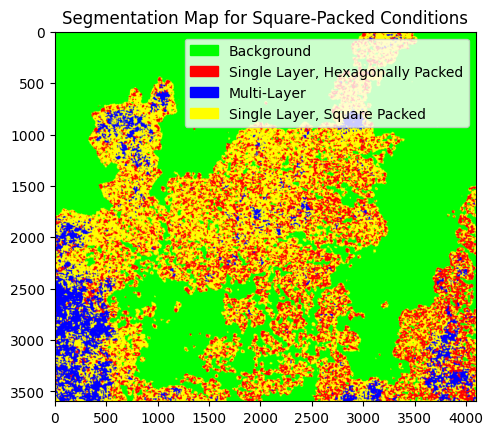

In [21]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as mpatches

# Load the trained segmentation model
# model = SegmentationModel(num_classes=4)  # Ensure num_classes matches your model
# model.load_state_dict(torch.load("path/to/your/trained_model.pth"))  # Update with your model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)
model.eval()

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Path for the TIFF image
image_path = "36kImages/36000 x 1822 Ceta.tif"

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
# Crop the image to remove the bottom 500 pixels
width, height = image.size
image = image.crop((0, 0, width, height - 500))  # (left, upper, right, lower)

# Transform the cropped image into a tensor
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the segmentation map
with torch.no_grad():
    output = model(input_tensor)  # Output shape: [1, num_classes, H, W]
    predicted_classes = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: [H, W]

# Define colormap for visualization
height, width = predicted_classes.shape
colormap = np.zeros((height, width, 3), dtype=np.uint8)

# Set colors for each class
class_colors = {
    0: (0, 255, 0),   # Background (Green)
    1: (0, 0, 255),   # Multi (Blue)
    2: (255, 0, 0),   # Single Hex (Red)
    3: (255, 255, 0), # Single Square (Yellow)
}

# Fill the colormap
for class_label, color in class_colors.items():
    colormap[predicted_classes == class_label] = color

# Calculate percentages
total_pixels = height * width
class_counts = [np.sum(predicted_classes == label) for label in class_colors.keys()]
percentages = [(count / total_pixels) * 100 for count in class_counts]

# Print percentages
print(f"Background: {percentages[0]:.2f}%")
print(f"Multi-Layer: {percentages[1]:.2f}%")
print(f"Single Hexagonal: {percentages[2]:.2f}%")
print(f"Single Square: {percentages[3]:.2f}%")


# Display the colormap
plt.imshow(colormap)
plt.title("Segmentation Map for Square-Packed Conditions")

# Define patches for each class with labels
background_patch = mpatches.Patch(color=(0, 1, 0), label='Background')  # Green
single_hex_patch = mpatches.Patch(color=(1, 0, 0), label='Single Layer, Hexagonally Packed')  # Red
multi_patch = mpatches.Patch(color=(0, 0, 1), label='Multi-Layer')  # Blue
single_square_patch = mpatches.Patch(color=(1, 1, 0), label='Single Layer, Square Packed')  # Yellow

# Add legend
plt.legend(handles=[background_patch, single_hex_patch, multi_patch, single_square_patch], loc='upper right')

# Show the plot
plt.show()

Background: 67.93%
Multi-Layer: 2.28%
Single Hexagonal: 29.18%
Single Square: 0.61%


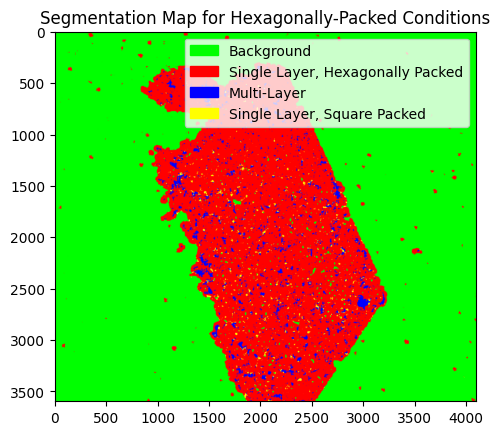

In [23]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as mpatches

# Load the trained segmentation model
# model = SegmentationModel(num_classes=4)  # Ensure num_classes matches your model
# model.load_state_dict(torch.load("path/to/your/trained_model.pth"))  # Update with your model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)
model.eval()

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Path for the TIFF image
image_path = "36kImages/36000 x 1410 Ceta.tif"

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
# Crop the image to remove the bottom 500 pixels
width, height = image.size
image = image.crop((0, 0, width, height - 500))  # (left, upper, right, lower)

# Transform the cropped image into a tensor
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the segmentation map
with torch.no_grad():
    output = model(input_tensor)  # Output shape: [1, num_classes, H, W]
    predicted_classes = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: [H, W]

# Define colormap for visualization
height, width = predicted_classes.shape
colormap = np.zeros((height, width, 3), dtype=np.uint8)

# Set colors for each class
class_colors = {
    0: (0, 255, 0),   # Background (Green)
    1: (0, 0, 255),   # Multi (Blue)
    2: (255, 0, 0),   # Single Hex (Red)
    3: (255, 255, 0), # Single Square (Yellow)
}

# Fill the colormap
for class_label, color in class_colors.items():
    colormap[predicted_classes == class_label] = color

# Calculate percentages
total_pixels = height * width
class_counts = [np.sum(predicted_classes == label) for label in class_colors.keys()]
percentages = [(count / total_pixels) * 100 for count in class_counts]

# Print percentages
print(f"Background: {percentages[0]:.2f}%")
print(f"Multi-Layer: {percentages[1]:.2f}%")
print(f"Single Hexagonal: {percentages[2]:.2f}%")
print(f"Single Square: {percentages[3]:.2f}%")


# Display the colormap
plt.imshow(colormap)
plt.title("Segmentation Map for Hexagonally-Packed Conditions")

# Define patches for each class with labels
background_patch = mpatches.Patch(color=(0, 1, 0), label='Background')  # Green
multi_patch = mpatches.Patch(color=(0, 0, 1), label='Multi-Layer')  # Blue
single_hex_patch = mpatches.Patch(color=(1, 0, 0), label='Single Layer, Hexagonally Packed')  # Red
single_square_patch = mpatches.Patch(color=(1, 1, 0), label='Single Layer, Square Packed')  # Yellow

# Add legend
plt.legend(handles=[background_patch, single_hex_patch, multi_patch, single_square_patch], loc='upper right')

# Show the plot
plt.show()

# Model Saving

In [19]:
# Save the model checkpoint
checkpoint_path = "segmentation_model_checkpoint.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Model checkpoint saved at {checkpoint_path}")

# Load the model checkpoint
model.load_state_dict(torch.load(checkpoint_path))
print("Model checkpoint loaded successfully")

Model checkpoint saved at segmentation_model_checkpoint.pth
